In [1]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind  # Add ttest_ind import
import csv
import yaml
import random
import re

In [2]:
# Load the processed data
adata = sc.read_h5ad("/Users/aumchampaneri/Databases/Triple/Hs_Nor-CKD-AKF_scRNA_processed.h5ad")

In [3]:
adata.var

,index,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells
ENSG00000243485,ENSG00000243485,False,MIR1302-2HG,NCBITaxon:9606,gene,623,lncRNA,5
ENSG00000238009,ENSG00000238009,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA,263
ENSG00000241860,ENSG00000241860,False,ENSG00000241860.7,NCBITaxon:9606,gene,1025,lncRNA,1057
ENSG00000286448,ENSG00000286448,False,ENSG00000286448.1,NCBITaxon:9606,gene,736,lncRNA,8
ENSG00000235146,ENSG00000235146,False,ENSG00000235146.2,NCBITaxon:9606,gene,504,lncRNA,6
...,...,...,...,...,...,...,...,...
ENSG00000277856,ENSG00000277856,False,ENSG00000277856.1,NCBITaxon:9606,gene,294,protein_coding,8
ENSG00000275063,ENSG00000275063,False,ENSG00000275063.1,NCBITaxon:9606,gene,351,protein_coding,33
ENSG00000273554,ENSG00000273554,False,ENSG00000273554.4,NCBITaxon:9606,gene,3345,protein_coding,12
ENSG00000278817,ENSG00000278817,False,ENSG00000278817.1,NCBITaxon:9606,gene,1213,protein_coding,7824


In [39]:
# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

# Change the name of some entries in gene_dict_names to fix plotting errors
gene_dict_names = [re.sub(r'\bC2\b', 'C2_ENSG00000166278', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC3\b', 'C3_ENSG00000125730', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC6\b', 'C6_ENSG00000039537', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC7\b', 'C7_ENSG00000112936', name) for name in gene_dict_names]
gene_dict_names = [re.sub(r'\bC9\b', 'C9_ENSG00000113600', name) for name in gene_dict_names]

# Load the tissue type dictionary from the yaml file
with open("Tissue Type Dictionary.yaml", "r") as file:
    cell_type_group = yaml.safe_load(file)

# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_group.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

## Test differential expression of complement genes in different disease states

In [30]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text

def volcano_plot(
    adata,
    gene_dict,
    group1="Reference",
    group2="AKI",
    logfc_thresh=1.0,
    pval_thresh=0.1,
    top_n=5,
    save_path=None,
    colors=None,
    method="t-test",
    annotate_fontsize=10,
    annotate_color="black",
    annotate_offset=0.02,
    annotate_method="adjust_text",
    debug=False
):
    """
    Creates a volcano plot and returns both the plot and the processed differential expression DataFrame.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
    gene_dict : dict
        Dictionary mapping Gene Names to Ensembl IDs.
    group1 : str, optional
        The reference group (default: 'Reference').
    group2 : str, optional
        The experimental/disease group to compare against group1 (default: 'AKI').
    logfc_thresh : float, optional
        Log fold change threshold (default: 1.0).
    pval_thresh : float, optional
        P-value threshold (default: 0.1).
    top_n : int, optional
        Number of genes to annotate (default: 5).
    save_path : str, optional
        If specified, saves the figure to this path.
    colors : dict, optional
        Custom colors for plot categories (default: None).
    method : str, optional
        Method for differential expression analysis (default: 't-test').

        Available methods:
        - "t-test": Standard parametric test assuming normality.
        - "t-test_overestim_var": Similar to t-test but with variance overestimation for stricter significance.
        - "wilcoxon": Non-parametric test robust to outliers, recommended for single-cell RNA-seq.
        - "logreg": Logistic regression, useful for finding genes that best classify groups.
    annotation_fontsize : int, optional
        Font size for gene annotations (default: 10).
    annotation_color : str, optional
        Color of annotation text (default: 'black').
    annotation_arrowprops : dict, optional
        Custom properties for annotation arrows (default: None).
        Example: {'arrowstyle': '->', 'lw': 1.5}.

    Returns
    -------
    tuple
        (matplotlib.figure.Figure, pd.DataFrame)
        - Figure object containing the volcano plot.
        - DataFrame with differential expression results.
    """
    ensembl_to_gene = {v: k for k, v in gene_dict.items()}

    if "diseasetype" not in adata.obs:
        raise ValueError("`diseasetype` column missing in adata.obs.")

    adata_subset = adata[adata.obs["diseasetype"].isin([group1, group2])].copy()

    if adata.raw is not None:
        adata_subset = adata.raw.to_adata()
        adata_subset = adata_subset[adata.obs["diseasetype"].isin([group1, group2])].copy()

    if np.max(adata_subset.X) > 100:
        sc.pp.log1p(adata_subset)

    sc.tl.rank_genes_groups(adata_subset, groupby="diseasetype", groups=[group2], reference=group1, method=method)

    if "rank_genes_groups" not in adata_subset.uns:
        raise ValueError("No differential expression results found. Ensure `rank_genes_groups` was run.")

    de_results = adata_subset.uns["rank_genes_groups"]
    if group2 not in de_results["names"].dtype.names:
        raise ValueError(f"Differential expression results missing for {group2}.")

    gene_ids = np.array(de_results["names"][group2])
    pvals = np.array(de_results["pvals"][group2])
    logfc = np.array(de_results["logfoldchanges"][group2])

    pvals = np.maximum(pvals, 1e-300)

    volcano_data = pd.DataFrame({
        "Ensembl_ID": gene_ids,
        "logFC": logfc,
        "-log10(p-value)": -np.log10(pvals),
        "Gene_Name": [ensembl_to_gene.get(gid, gid) for gid in gene_ids]
    })

    volcano_data["Significance"] = "Not Significant"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] > logfc_thresh),
        "Significance"
    ] = "Upregulated"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] < -logfc_thresh),
        "Significance"
    ] = "Downregulated"

    if debug:
        print("Total genes:", len(volcano_data))
        print("Significance breakdown:\n", volcano_data["Significance"].value_counts())

    if colors is None:
        colors = {"Not Significant": "gray", "Upregulated": "red", "Downregulated": "blue"}

    fig, ax = plt.subplots(figsize=(10, 8))
    for sig, color in colors.items():
        subset = volcano_data[volcano_data["Significance"] == sig]
        ax.scatter(subset["logFC"], subset["-log10(p-value)"],
                   c=color, edgecolors="black", label=sig, s=50, alpha=0.6)

    top_genes = volcano_data.loc[volcano_data["logFC"].abs().nlargest(top_n).index]
    texts = []

    for _, row in top_genes.iterrows():
        text = ax.text(
            row["logFC"], row["-log10(p-value)"] + annotate_offset, row["Gene_Name"],
            fontsize=annotate_fontsize, color=annotate_color, ha="right", va="bottom"
        )
        texts.append(text)

    if annotate_method == "adjust_text":
        adjust_text(texts, arrowprops=dict(arrowstyle="->", lw=1.5))

    ax.axhline(y=-np.log10(pval_thresh), color="black", linestyle="--", label=f"p = {pval_thresh}")
    ax.axvline(x=logfc_thresh, color="black", linestyle="--", label=f"logFC = {logfc_thresh}")
    ax.axvline(x=-logfc_thresh, color="black", linestyle="--")

    ax.set_xlabel("Log Fold Change (logFC)")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"Volcano Plot: {group2} vs {group1} ({method})")
    ax.legend()

    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    else:
        plt.show()

    return fig, volcano_data

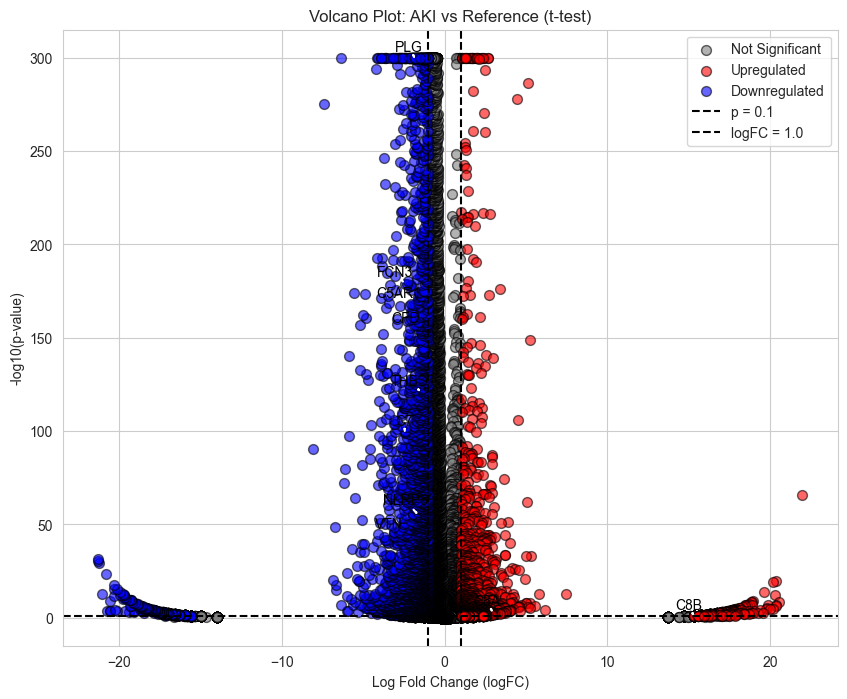

(<Figure size 1000x800 with 1 Axes>,
             Ensembl_ID     logFC  -log10(p-value) Gene_Name     Significance
 20     ENSG00000205403  0.912437       300.000000       CFI  Not Significant
 82     ENSG00000125730  1.160236       172.389087        C3      Upregulated
 311    ENSG00000149131  0.321250        58.894150  SERPING1  Not Significant
 601    ENSG00000137752  0.441766        31.304256     CASP1  Not Significant
 954    ENSG00000064012  0.280432        16.682543     CASP8  Not Significant
 ...                ...       ...              ...       ...              ...
 30609  ENSG00000196352 -1.055305       298.219173      CD55    Downregulated
 30667  ENSG00000130203 -0.841352       300.000000      APOE  Not Significant
 30758  ENSG00000122194 -1.840624       300.000000       PLG    Downregulated
 30894  ENSG00000168610 -0.760641       300.000000     STAT3  Not Significant
 31197  ENSG00000080824 -0.708565       300.000000  HSP90AA1  Not Significant
 
 [61 rows x 5 columns])

In [40]:
volcano_plot(
    adata,
    gene_dict,
    group1="Reference",
    group2="AKI",
    logfc_thresh=1.0,
    pval_thresh=0.1,
    top_n=10,
    method="t-test")

In [37]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os

def volcano_plot(
    adata,
    gene_dict,
    group1="Reference",
    group2="AKI",
    logfc_thresh=1.0,
    pval_thresh=0.1,
    top_n=5,
    save_path=None,
    colors=None,
    method="t-test",
    annotate_fontsize=10,
    annotate_color="black",
    annotate_offset=0.02,
    annotate_method="adjust_text",
    debug=False
):
    """
    Creates a volcano plot and returns both the plot and the processed differential expression DataFrame.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
    gene_dict : dict
        Dictionary mapping Gene Names to Ensembl IDs.
    group1 : str, optional
        The reference group (default: 'Reference').
    group2 : str, optional
        The experimental/disease group to compare against group1 (default: 'AKI').
    logfc_thresh : float, optional
        Log fold change threshold (default: 1.0).
    pval_thresh : float, optional
        P-value threshold (default: 0.1).
    top_n : int, optional
        Number of genes to annotate (default: 5).
    save_path : str, optional
        If specified, saves the figure to this path.
    colors : dict, optional
        Custom colors for plot categories (default: None).
    method : str, optional
        Method for differential expression analysis (default: 't-test').

        Available methods:
        - "t-test": Standard parametric test assuming normality.
        - "t-test_overestim_var": Similar to t-test but with variance overestimation for stricter significance.
        - "wilcoxon": Non-parametric test robust to outliers, recommended for single-cell RNA-seq.
        - "logreg": Logistic regression, useful for finding genes that best classify groups.
    annotation_fontsize : int, optional
        Font size for gene annotations (default: 10).
    annotation_color : str, optional
        Color of annotation text (default: 'black').
    annotation_arrowprops : dict, optional
        Custom properties for annotation arrows (default: None).
        Example: {'arrowstyle': '->', 'lw': 1.5}.

    Returns
    -------
    tuple
        (matplotlib.figure.Figure, pd.DataFrame)
        - Figure object containing the volcano plot.
        - DataFrame with differential expression results.
    """
    ensembl_to_gene = {v: k for k, v in gene_dict.items()}

    if "diseasetype" not in adata.obs:
        raise ValueError("`diseasetype` column missing in adata.obs.")

    adata_subset = adata[adata.obs["diseasetype"].isin([group1, group2])].copy()

    if adata.raw is not None:
        adata_subset = adata.raw.to_adata()
        adata_subset = adata_subset[adata.obs["diseasetype"].isin([group1, group2])].copy()

    if np.max(adata_subset.X) > 100:
        sc.pp.log1p(adata_subset)

    sc.tl.rank_genes_groups(adata_subset, groupby="diseasetype", groups=[group2], reference=group1, method=method)

    if "rank_genes_groups" not in adata_subset.uns:
        raise ValueError("No differential expression results found. Ensure `rank_genes_groups` was run.")

    de_results = adata_subset.uns["rank_genes_groups"]
    if group2 not in de_results["names"].dtype.names:
        raise ValueError(f"Differential expression results missing for {group2}.")

    gene_ids = np.array(de_results["names"][group2])
    pvals = np.array(de_results["pvals"][group2])
    logfc = np.array(de_results["logfoldchanges"][group2])

    pvals = np.maximum(pvals, 1e-300)

    volcano_data = pd.DataFrame({
        "Ensembl_ID": gene_ids,
        "logFC": logfc,
        "-log10(p-value)": -np.log10(pvals),
        "Gene_Name": [ensembl_to_gene.get(gid, gid) for gid in gene_ids]
    })

    volcano_data["Significance"] = "Not Significant"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] > logfc_thresh),
        "Significance"
    ] = "Upregulated"
    volcano_data.loc[
        (volcano_data["-log10(p-value)"] > -np.log10(pval_thresh)) & (volcano_data["logFC"] < -logfc_thresh),
        "Significance"
    ] = "Downregulated"

    if debug:
        print("Total genes:", len(volcano_data))
        print("Significance breakdown:\n", volcano_data["Significance"].value_counts())

    if colors is None:
        colors = {"Not Significant": "gray", "Upregulated": "red", "Downregulated": "blue"}

    fig, ax = plt.subplots(figsize=(10, 8))
    for sig, color in colors.items():
        subset = volcano_data[volcano_data["Significance"] == sig]
        ax.scatter(subset["logFC"], subset["-log10(p-value)"],
                   c=color, edgecolors="black", label=sig, s=50, alpha=0.6)

    # Filter to include only genes in gene_dict
    volcano_data = volcano_data[volcano_data["Gene_Name"].isin(gene_dict.keys())]

    top_genes = volcano_data.loc[volcano_data["logFC"].abs().nlargest(top_n).index]
    texts = []

    for _, row in top_genes.iterrows():
        text = ax.text(
            row["logFC"], row["-log10(p-value)"] + annotate_offset, row["Gene_Name"],
            fontsize=annotate_fontsize, color=annotate_color, ha="right", va="bottom"
        )
        texts.append(text)

    if annotate_method == "adjust_text":
        adjust_text(texts, arrowprops=dict(arrowstyle="->", lw=1.5))

    ax.axhline(y=-np.log10(pval_thresh), color="black", linestyle="--", label=f"p = {pval_thresh}")
    ax.axvline(x=logfc_thresh, color="black", linestyle="--", label=f"logFC = {logfc_thresh}")
    ax.axvline(x=-logfc_thresh, color="black", linestyle="--")

    ax.set_xlabel("Log Fold Change (logFC)")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"Volcano Plot: {group2} vs {group1} ({method})")
    ax.legend()

    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
        # Save the DataFrame as CSV or Excel
        file_name, file_extension = os.path.splitext(save_path)
        # csv_path = f"{file_name}.csv"
        excel_path = f"{file_name}.xlsx"
        # volcano_data.to_csv(csv_path, index=False)
        volcano_data.to_excel(excel_path, index=False)
    else:
        plt.show()

    return fig, volcano_data